# **`flygym`-MuJoCo tutorial:** Replay of recorded behavior

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_replay.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).

In particular, you're encouraged to read the following pages on the documentation before proceeding with this tutorial:
- [The NeuroMechFly Model](https://nely-epfl.github.io/flygym/neuromechfly.html)
- [Interacting with an Environment](https://nely-epfl.github.io/flygym/environments/index.html)
- [The former demo on basic control](https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_sinewave.ipynb)

In [ ]:
#@title Install `flygym` on Colab

# This block is modified from dm_control's tutorial notebook
# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

print('Installing flygym')
!pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during dm_control installation. Check the shell '
        'output above for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

print('Checking that the flygym installation succeeded...')
try:
    import flygym
    from flygym import envs
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during flygym installation. Check the shell '
        'output above for more information.\n')
else:
    del envs, flygym

In [10]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

---

This notebook demonstrates another simple controller: replaying recorded fly behavior. We take fly limb kinematics tracked by [*DeepFly3D*](https://elifesciences.org/articles/48571), a machine-learning-based software for predicting joint keypoint location in 3D in an experimental setup like the following, and replay the joint movements in our simulated environment.

 <img src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/df3d.jpg" alt="DeepFly3D" width="1000"> <figcaption>Source: Günel et al (2019) https://elifesciences.org/articles/48571</figcaption>

Note that the fly is tethered on a air-suspended spherical treadmill. We can nevertheless let our simulated fly walk freely on the floor using the tracked joint movements, although the walking is not totally realistic.

Similar to the previous demo, we start by initializing the simulation environment:

In [11]:
# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs)

We then load the recorded limb joint movements. This data file comes with the FlyGym package installation and you can find it with `pkg_resources.resource_filename`:

In [12]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)

The data is in the form of a dictionary. Each key is a joint degree of freedom (Dof). The corresponding value is a time series of that DoF. Additionally, there's a key `'meta'` that maps to some metadata of the recording:

In [13]:
print('Dict keys:', data.keys())
print('Length of time series:', len(data['joint_RFCoxa']))
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa_yaw', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa_yaw', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa_yaw', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa_yaw', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa_yaw', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa_yaw', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: 2000
Metadata: {'timestep': 0.0005, 'source_file': '/home/sibwang/Downloads/joint_angles__210902_PR_Fly1.pkl', 'time_range': (3.0, 4.0)}


Notice that the metadata shows that the kinematic tracking time series is 1-second long (from t=3 to t=4 in some recording file), and that temporal resolution is 0.0005 seconds per step. Our simulation (as defined above) runs at a timestep of 0.0001s. This is 5 times faster. Therefore, we need to interpolate our recording.

In general, we want to use a very small time step in the physics simulation. Camera recordings and 3D pose instructions are often way coarser. Therefore, interpolation is often mandatory.

We further put the data into a NumPy array of shape (num_joints, num_steps). This way, at the i-th time step, we can simply take i-th column of the array as our joint control signals:

In [14]:
# Interpolate 5x
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

Let's visualze some recorded joint time series:

Text(0, 0.5, 'Angle (radian)')

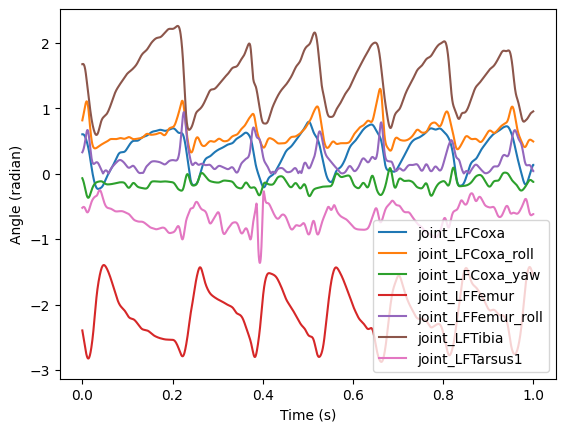

In [15]:
num_joints_to_visualize = 7
plt.plot(np.arange(data_block.shape[1]) * nmf.timestep,
         data_block[:num_joints_to_visualize].T,
         label=nmf.actuated_joints[:num_joints_to_visualize])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (radian)')

Now, we're ready to run our simulation. Tip: this we can use `trange` from the [`tqdm` package](https://github.com/tqdm/tqdm) to add a progress bar. It works the same as Python's built-in `range`, but with a progress bar. You can also use `tqdm.tqdm` on a simple for-loop (without `range`).

In [16]:
# Run simulation
obs, info = nmf.reset()

obs_list = [obs]
for i in trange(num_steps):
    joint_pos = data_block[:, i]
    action = {'joints': joint_pos}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)

100%|██████████| 10000/10000 [00:16<00:00, 609.55it/s]


As before, we save and inspect the video:

In [17]:
video_path = Path('kin_replay/video.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

As previously explained, the on-the-ball walking behavior is not entirely realistic when released on the floor. Nonetheless, this serves as a proof-of-concept.